<a href="https://colab.research.google.com/github/gandhimonil9823/Covid_Stock_Analysis/blob/main/Covid_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -q libgeos-3.5.0
!apt-get install -q libgeos-dev
!pip install -q https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists...
Building dependency tree...
Reading state information...
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists...
Building dependency tree...
Reading state information...
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 73.1 kB of archives.
After this operation, 486 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Fetched 73.1 kB in 1s (117 kB/s)
Selecting previously unselected package libgeos-dev.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../libgeos-dev_3.6.2-1build2_amd64.deb ...
Unpacking libgeos-dev (3.6.2-1build2) ...
Setting up libgeos-dev (3.6.2-1build2) ...
Processing trigge

In [2]:
!pip install -q pyproj==1.9.6

     |████████████████████████████████| 2.8MB 8.7MB/s 


In [76]:
!pip install pathpy
!pip install pyramid-arima
!pip install statsmodels

In [4]:
!pip install sklearn

In [103]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
import pandas as pd
import matplotlib.pyplot as plt
import os
import statistics 
import numpy as np
%matplotlib inline
import itertools
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report
import math
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings 
warnings.filterwarnings('ignore')
import statsmodels as sm
from pyramid.arima import auto_arima
import pathpy as pp


In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [8]:
# Merging the Stock Indexes and the currency data with rows as dates and columns as index values
# Preprocessing the data sets with online steps for data processing 
# Figuring a way to convert the unemployment data into county wise data - probably using a probability distribution
# Deal with missing stock data for weekends and holidays

Stock Data: Pre-processing


In [78]:
# Reading CSVs for three stock indices
df = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/stock_data/DJI.csv")
df_DJI = df[["Date", "Adj Close", "Volume"]]

df = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/stock_data/NASDAQ.csv")
df_NASDAQ = df[["Date", "Adj Close", "Volume"]]

df_snp500_original = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/stock_data/S&P500.csv")

df_SP500 = df_snp500_original[["Date", "Adj Close", "Volume"]]

df_covid_clean_complete = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/COVID_19/covid_19_clean_complete.csv")

trend_seasonality_df = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/COVID_19/trend_seasonality_covid.csv")


df_centroid = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/COVID_19/pre_processed_centroid.csv")

df_with_missing = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/stock_data/stock_closing_prices_188.csv")
df_with_missing_historical = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/stock_data/historical_data_filled_188.csv")

In [67]:
# Reading CSVs for three stock indices
# df = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/stock_data/DJI.csv")
# df_DJI = df[["Date", "Adj Close", "Volume"]]

# df = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/stock_data/NASDAQ.csv")
# df_NASDAQ = df[["Date", "Adj Close", "Volume"]]

# df_snp500_original = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/stock_data/S&P500.csv")

# df_SP500 = df_snp500_original[["Date", "Adj Close", "Volume"]]

# df_covid_clean_complete = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/COVID_19/covid_19_clean_complete.csv")

# trend_seasonality_df = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/COVID_19/trend_seasonality_covid.csv")


# df_centroid = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/COVID_19/pre_processed_centroid.csv")

df_with_missing = pd.read_csv("/content/drive/Shareddrives/Stock_Covid_Data/stock_data/Stock_2016_2020 - Sheet1 (1).csv")
# df_with_missing_historical = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/stock_data/historical_data_filled_188.csv")

In [12]:
# # Rename columns in each index in order to merge the indices 
# df_NASDAQ = df_NASDAQ.rename(columns={'Adj Close': 'Adj_Close_NASDAQ', 'Volume': 'Volume_NASDAQ'})
# df_SP500 = df_SP500.rename(columns={'Adj Close': 'Adj_Close_SP500', 'Volume': 'Volume_SP500'})
# df_DJI = df_DJI.rename(columns={'Adj Close': 'Adj_Close_DJI', 'Volume': 'Volume_DJI'})

In [13]:
# # Merging data of three stock indices based on column: 'Date' (merging two DFs at once)
# df_Merged = pd.merge(df_SP500, df_DJI, on=['Date'])
# df_stock_data = pd.merge(df_Merged, df_NASDAQ, on=['Date'])

In [14]:
df_with_missing.describe()

,Adj_Close_SP500,Adj_Close_DJI,Adj_Close_NASDAQ
count,188.000000,188.000000,188.000000
mean,2994.051288,25330.678570,9125.304665
std,268.659703,2475.166771,965.157073
min,2237.399902,18591.929690,6860.669922
25%,2839.823842,23747.586447,8573.557617
50%,3042.760740,25600.669920,9274.280274
75%,3216.602093,26711.167968,9800.551478
max,3386.149902,29551.419920,10767.089840


In [15]:
df_with_missing['Adj_Close_SP500']

0      3321.750000
1      3325.540039
2      3295.469971
3      3278.098532
4      3260.818664
          ...     
183    3235.659912
184    3215.629883
185    3223.537100
186    3231.463760
187    3239.409912
Name: Adj_Close_SP500, Length: 188, dtype: float64

# COVID - 19 Data Analysis and Clustering

## Data Loading and Preprocessing



In [20]:
# Function to load the covid_clean_complete dataset from the drive
def load_dataset_us_cases():  
  df_covid_clean_complete = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/COVID_19/covid_19_clean_complete.csv")
  return df_covid_clean_complete

# Function to preprocess the clean_complete_dataset
def preprocess_us_cases_df():
  df_US_daily_cases = load_dataset_us_cases()

  # get the daily data only for US
  df_US_daily_cases = df_covid_clean_complete.loc[df_covid_clean_complete['Country/Region'] == "US"]
  
  df_US_daily_cases = df_US_daily_cases.reset_index(drop=True)

  # Added a column for new_cases daily by getting the differerence of the confirmed cases
  df_US_daily_cases["New_cases"] = df_US_daily_cases["Confirmed"].diff()
  
  df_US_daily_cases['New_cases'] = df_US_daily_cases['New_cases'].fillna(0)

  df_US_daily_cases = df_US_daily_cases.rename(columns={"Confirmed": "Total_Confirmed", "Deaths" : "Total_Deaths"})

  return df_US_daily_cases


## Standardize the COVID variables like New_cases, Total_cases, Total_deaths

In [21]:
# Function to standardize the covid_variables like New_cases, Total_cases, Total_deaths
# Adds new columns to the df with the standarized values
# params - the dataframe, and the column name (COVID Variable) which has to be standarized
def covid_variable_impact_cal(dataframe_to_standardize, column_name):

  col_name = "Standardized_Value_" + column_name
  dataframe_to_standardize[col_name] = dataframe_to_standardize[column_name]

  i = 0
  j = 0
  while i < len(dataframe_to_standardize):
    j = i
    if i > 7:
      col_mean = dataframe_to_standardize[column_name][j - 8: j - 1].mean()
      col_std  = statistics.stdev(dataframe_to_standardize[column_name][j - 8: j - 1])

      curr_daily_value = dataframe_to_standardize[column_name][i]

      formula_cal_value = (curr_daily_value - col_mean) / col_std

      dataframe_to_standardize.loc[i, col_name] = formula_cal_value

    i += 1
  dataframe_to_standardize[col_name].replace(np.inf, 0, inplace=True)
  return dataframe_to_standardize

In [23]:
df_US_daily_cases = preprocess_us_cases_df()
df_US_daily_cases.head()



,Province/State,Country/Region,Lat,Long,Date,Total_Confirmed,Total_Deaths,Recovered,Active,WHO Region,New_cases
0,NaN,US,40.0,-100.0,2020-01-22,1,0,0,1,Americas,0.0
1,NaN,US,40.0,-100.0,2020-01-23,1,0,0,1,Americas,0.0
2,NaN,US,40.0,-100.0,2020-01-24,2,0,0,2,Americas,1.0
3,NaN,US,40.0,-100.0,2020-01-25,2,0,0,2,Americas,0.0
4,NaN,US,40.0,-100.0,2020-01-26,5,0,0,5,Americas,3.0


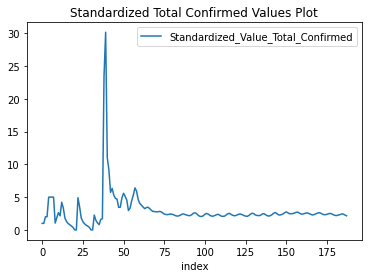

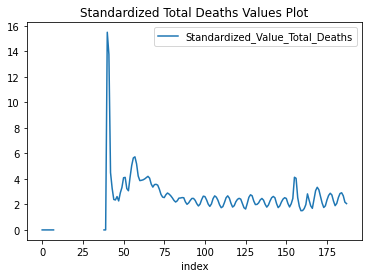

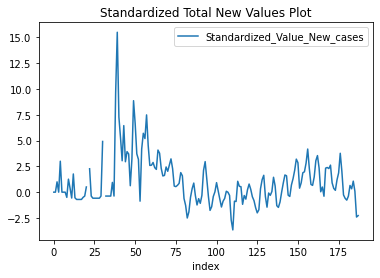

In [28]:
df_standarized_total_confirmed = covid_variable_impact_cal(df_US_daily_cases, "Total_Confirmed")

df_standarized_total_confirmed.reset_index().plot(x='index', y='Standardized_Value_Total_Confirmed', title= "Standardized Total Confirmed Values Plot")    

df_standarized_Total_Deaths = covid_variable_impact_cal(df_US_daily_cases, "Total_Deaths")

df_standarized_Total_Deaths.reset_index().plot(x='index', y='Standardized_Value_Total_Deaths', title= "Standardized Total Deaths Values Plot")

df_standarized_New_cases = covid_variable_impact_cal(df_US_daily_cases, "New_cases")

df_standarized_New_cases.reset_index().plot(x='index', y='Standardized_Value_New_cases', title= "Standardized Total New Values Plot")

# Complex Network Analysis for Trend and Seasonality


### Example for calculating the Trend and Seasonaly for Santa Clara County in terms of New Cases

            New_cases
Date                 
2020-04-01         66
2020-04-02         63
2020-04-04        129
2020-04-05         59
2020-04-07         78
...               ...
2020-07-23        212
2020-07-24        186
2020-07-25        114
2020-07-26        208
2020-07-27        174

[105 rows x 1 columns]


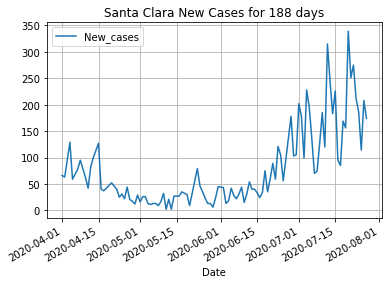

In [95]:
df_santa_clara = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/COVID_19/santa_clara_new.csv")
df_santa_clara.drop(df_santa_clara.filter(regex="Unname"),axis=1, inplace=True)
df_santa_clara["Date"] = pd.to_datetime(df_santa_clara["Date"])
df_santa_clara = df_santa_clara.set_index("Date")
df_santa_clara_date = df_santa_clara[["New_cases"]]
df_santa_clara_date.plot(grid=True, title= "Santa Clara New Cases for 188 days")
# df_santa_clara_date.sort_index(inplace= True)
print(df_santa_clara_date)

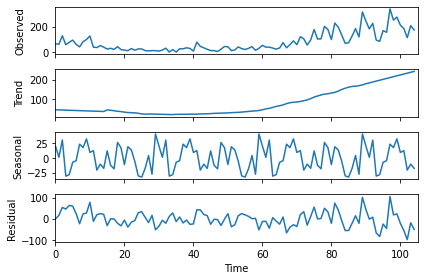

In [99]:
decomposition_seasonal= seasonal_decompose(df_santa_clara_date["New_cases"].values, freq=30, extrapolate_trend='freq')
residual = decomposition_seasonal.resid
seasonal = decomposition_seasonal.seasonal 
trend = decomposition_seasonal.trend
fig = decomposition_seasonal.plot()


In [100]:
#Function to have each county in aombination with another county in the same bin
def combinations_bin_counties(df_original):
    counties  = df_original["Combined_Key"]

    list_of_counties_combinations = list(itertools.combinations(counties,2))

    df_to_return = pd.DataFrame({"Combinations" : list_of_counties_combinations})

    return df_to_return

In [104]:
# Running the cluster analysis based on Trend for each other on a single day
# For the below code the prototype is only shown for day "2020-4-15" as an example, the same procedure can be done for all the 188 days
groupby_daily = trend_seasonality_df.groupby(trend_seasonality_df["Date"])
g = None
for name, group in groupby_daily: 
  if name == "2020-4-15" :
    G_t = pp.Network(directed=False)

    group['bin'] = pd.qcut(group['Trend'], q=30, duplicates='drop')

    groupby_bin = group.groupby(group["bin"])
    for name_bin, group_bin in groupby_bin:
      df_comb_counties_bin = combinations_bin_counties(group_bin)
      for index_group, row_group in group_bin.iterrows():
        if row_group["New_cases"] >= 10:
          G_t.add_node(str(row_group["Combined_Key"]))
      for index_bin, row_bin in df_comb_counties_bin.iterrows():
        tuple_county = row_bin["Combinations"]
        if str(tuple_county[0]) in G_t.nodes and str(tuple_county[1]) in G_t.nodes:
          G_t.add_edge(str(tuple_county[0]), str(tuple_county[1]))      
    g = G_t



style = {'width': 2000, 
          'height': 1000
        }
pp.visualisation.plot(g,**style)



## Computing Stock paramaters:


In [ ]:
# df_snp500 = df_with_missing[['Date','Adj_Close_SP500']]
# df_snp500.set_index('Date', inplace = True)
# df_snp500['Adj_Close_SP500'] = df_snp500['Adj_Close_SP500'].astype(float)

# df_snp500.shape
# df_with_missing.set_index('Date', inplace = True)

df_stock_pre_covid = df_with_missing[:1480]
df_stock_covid = df_with_missing[1480:]

# df_snp500.set_index('Date', inplace = True)
# df_snp500['Adj_Close_SP500'] = df_snp500['Adj_Close_SP500'].astype(float)

df_train = df_stock_pre_covid[:1297]
df_test = pd.concat([df_stock_pre_covid[1297:], df_stock_covid])

df_snp500_precovid, df_dji_precovid, df_nasdaq_precovid = df_stock_pre_covid[['Adj_Close_SP500']], df_stock_pre_covid[['Adj_Close_DJI']], df_stock_pre_covid[['Adj_Close_NASDAQ']]
df_snp500_covid, df_dji_covid, df_nasdaq_covid = df_stock_covid[['Adj_Close_SP500']], df_stock_covid[['Adj_Close_DJI']], df_stock_covid[['Adj_Close_NASDAQ']]

df_snp500_train, df_dji_train, df_nasdaq_train = df_train[['Adj_Close_SP500']], df_train[['Adj_Close_DJI']], df_train[['Adj_Close_NASDAQ']]
df_snp500_test, df_dji_test, df_nasdaq_test = df_test[['Adj_Close_SP500']], df_test[['Adj_Close_DJI']], df_test[['Adj_Close_NASDAQ']]

<Figure size 432x288 with 0 Axes>

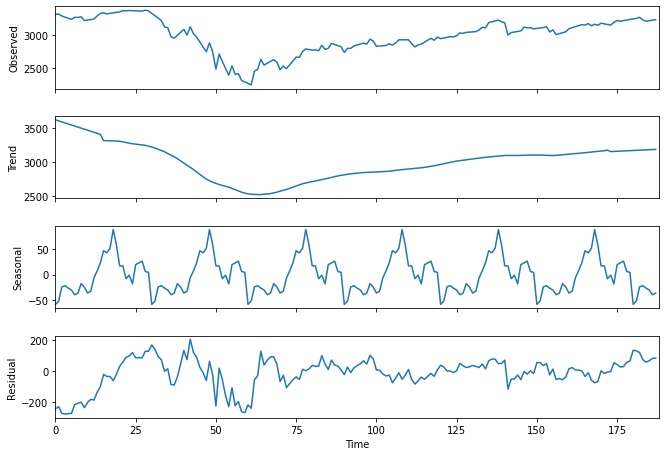

In [ ]:
result = seasonal_decompose(df_snp500_covid.values, model='additive', freq=30, extrapolate_trend='freq')

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(10, 7)

<Figure size 432x288 with 0 Axes>

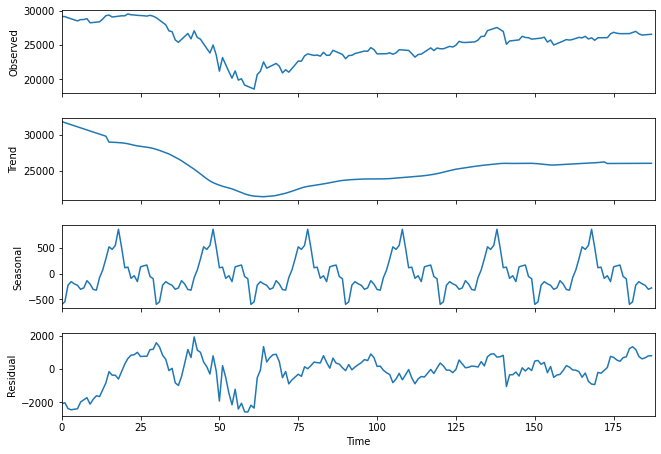

In [ ]:
result = seasonal_decompose(df_dji_covid.values, model='additive', freq=30, extrapolate_trend='freq')

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(10, 7)

<Figure size 432x288 with 0 Axes>

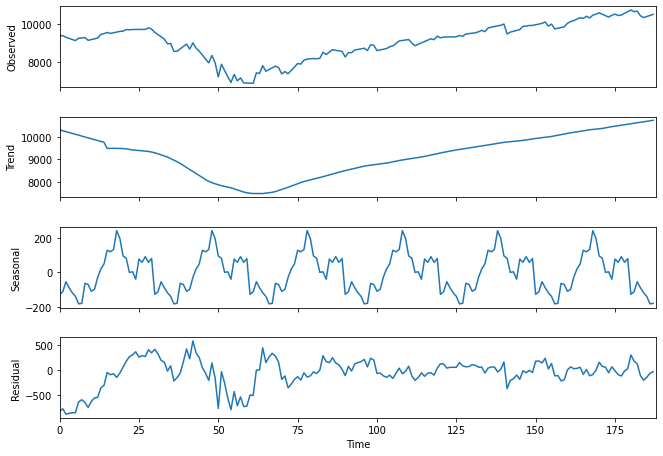

In [ ]:
result = seasonal_decompose(df_nasdaq_covid.values, model='additive', freq=30, extrapolate_trend='freq')

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(10, 7)

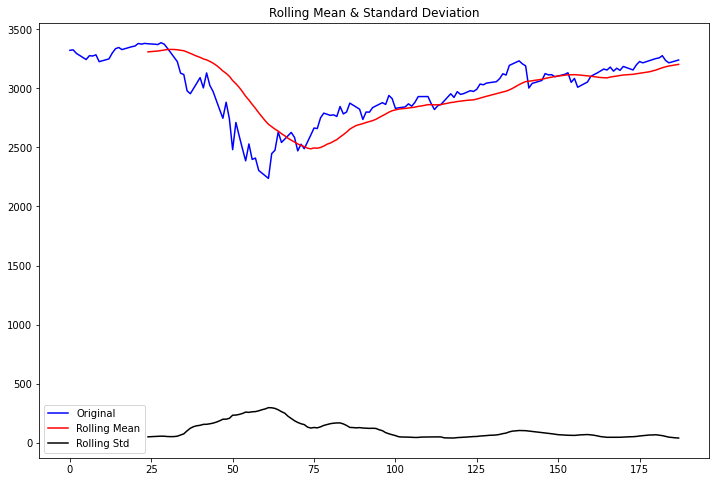

Results of Dickey-Fuller Test:
p-value = 0.4055. The series is likely non-stationary.
Test Statistic                  -1.750116
p-value                          0.405494
#Lags Used                      11.000000
Number of Observations Used    176.000000
Critical Value (1%)             -3.468062
Critical Value (5%)             -2.878106
Critical Value (10%)            -2.575602
dtype: float64


In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 25, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.values, color='blue',label='Original')
    mean = plt.plot(rolmean.values, color='red', label='Rolling Mean')
    std = plt.plot(rolstd.values, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

test_stationarity(df_snp500_covid['Adj_Close_SP500'])

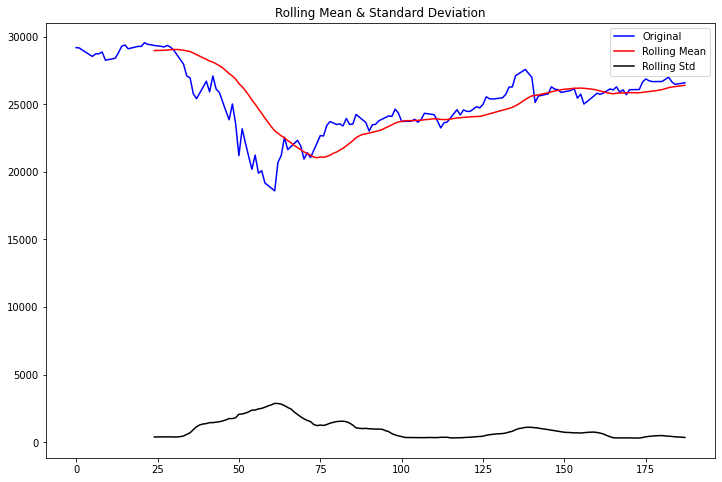

Results of Dickey-Fuller Test:
p-value = 0.3118. The series is likely non-stationary.
Test Statistic                  -1.943582
p-value                          0.311845
#Lags Used                      11.000000
Number of Observations Used    176.000000
Critical Value (1%)             -3.468062
Critical Value (5%)             -2.878106
Critical Value (10%)            -2.575602
dtype: float64


In [ ]:
test_stationarity(df_dji_covid['Adj_Close_DJI'])

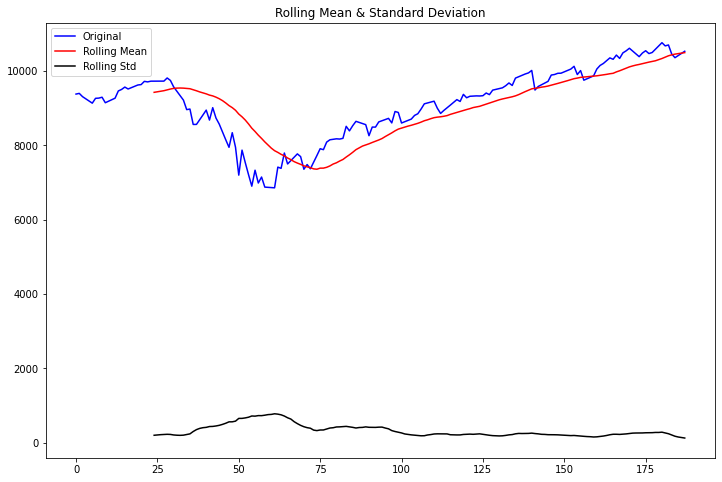

Results of Dickey-Fuller Test:
p-value = 0.7544. The series is likely non-stationary.
Test Statistic                  -0.996830
p-value                          0.754419
#Lags Used                      11.000000
Number of Observations Used    176.000000
Critical Value (1%)             -3.468062
Critical Value (5%)             -2.878106
Critical Value (10%)            -2.575602
dtype: float64


In [ ]:
test_stationarity(df_nasdaq_covid['Adj_Close_NASDAQ'])

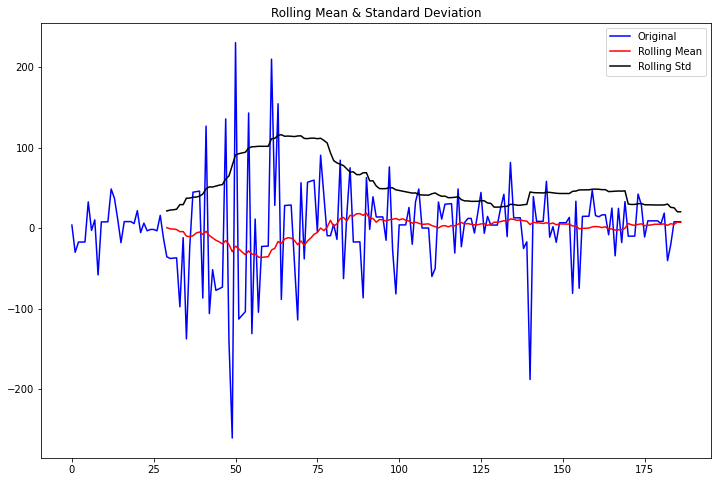

Results of Dickey-Fuller Test:
p-value = 0.0246. The series is likely non-stationary.
Test Statistic                  -3.126904
p-value                          0.024625
#Lags Used                      10.000000
Number of Observations Used    176.000000
Critical Value (1%)             -3.468062
Critical Value (5%)             -2.878106
Critical Value (10%)            -2.575602
dtype: float64


In [ ]:
df_snp500_covid['SP_First_Difference'] = df_snp500_covid['Adj_Close_SP500'] - df_snp500_covid['Adj_Close_SP500'].shift(1)
test_stationarity(df_snp500_covid['SP_First_Difference'].dropna(), window = 30)

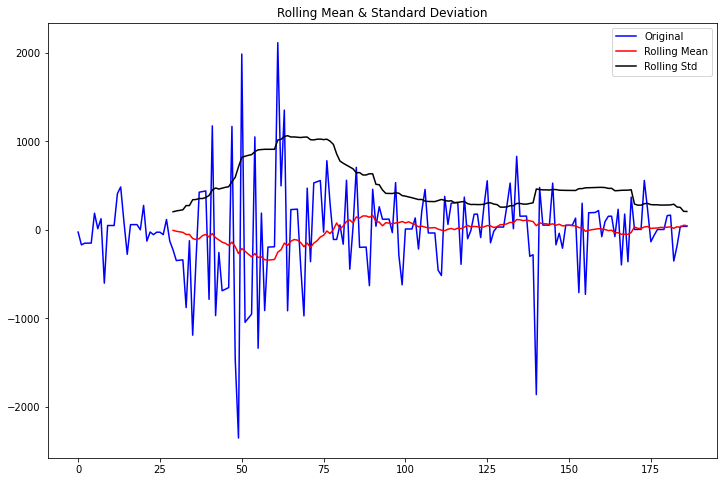

Results of Dickey-Fuller Test:
p-value = 0.0157. The series is likely non-stationary.
Test Statistic                  -3.282198
p-value                          0.015693
#Lags Used                      10.000000
Number of Observations Used    176.000000
Critical Value (1%)             -3.468062
Critical Value (5%)             -2.878106
Critical Value (10%)            -2.575602
dtype: float64


In [ ]:
df_dji_covid['DJI_First_Difference'] = df_dji_covid['Adj_Close_DJI'] - df_dji_covid['Adj_Close_DJI'].shift(1)
test_stationarity(df_dji_covid['DJI_First_Difference'].dropna(), window = 30)

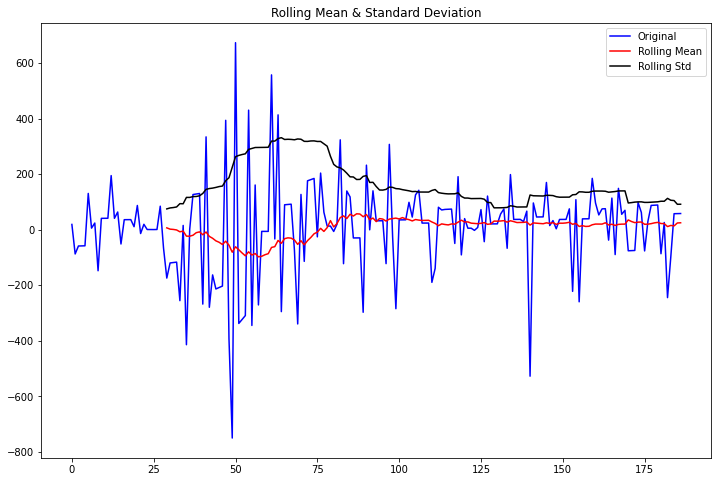

Results of Dickey-Fuller Test:
p-value = 0.0255. The series is likely non-stationary.
Test Statistic                  -3.114664
p-value                          0.025487
#Lags Used                      10.000000
Number of Observations Used    176.000000
Critical Value (1%)             -3.468062
Critical Value (5%)             -2.878106
Critical Value (10%)            -2.575602
dtype: float64


In [ ]:
df_nasdaq_covid['NAS_First_Difference'] = df_nasdaq_covid['Adj_Close_NASDAQ'] - df_nasdaq_covid['Adj_Close_NASDAQ'].shift(1)
test_stationarity(df_nasdaq_covid['NAS_First_Difference'].dropna(), window = 30)

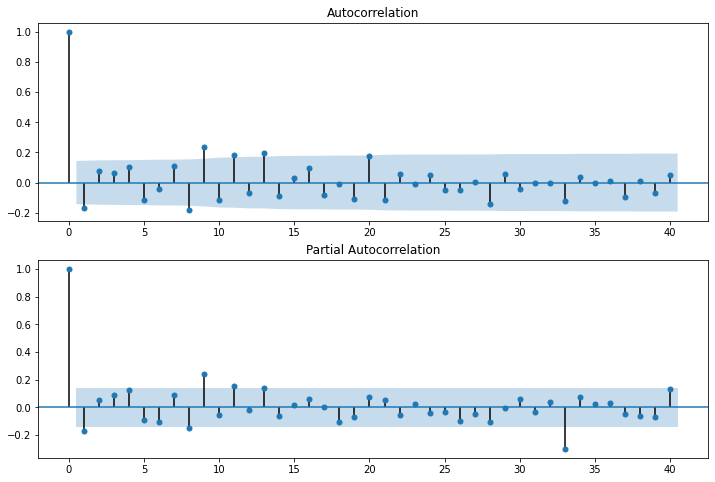

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.api.graphics.tsa.plot_acf(df_snp500_covid['SP_First_Difference'].dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.api.graphics.tsa.plot_pacf(df_snp500_covid['SP_First_Difference'].dropna(), lags=40, ax=ax2)

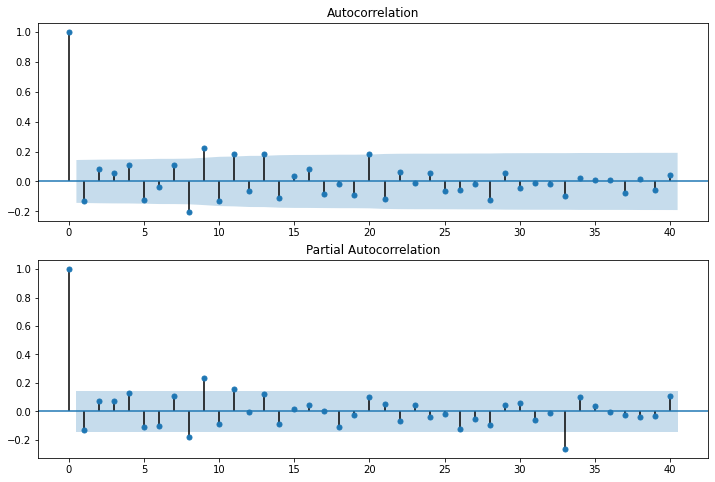

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.api.graphics.tsa.plot_acf(df_dji_covid['DJI_First_Difference'].dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.api.graphics.tsa.plot_pacf(df_dji_covid['DJI_First_Difference'].dropna(), lags=40, ax=ax2)

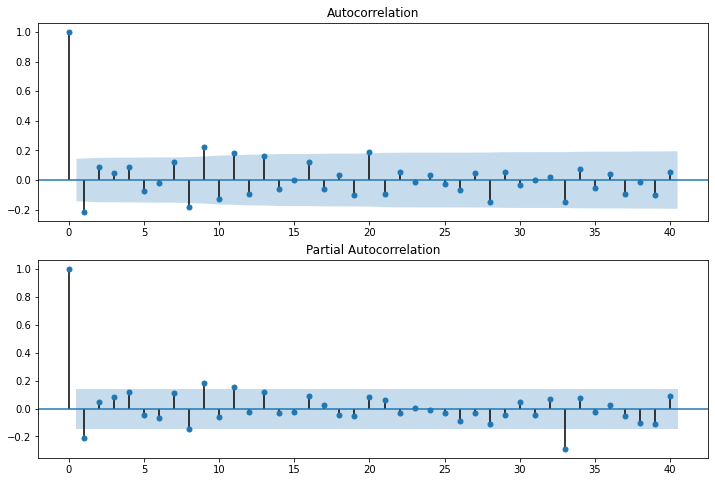

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.api.graphics.tsa.plot_acf(df_nasdaq_covid['NAS_First_Difference'].dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.api.graphics.tsa.plot_pacf(df_nasdaq_covid['NAS_First_Difference'].dropna(), lags=40, ax=ax2)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:      D.Adj_Close_SP500   No. Observations:                  187
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1019.046
Method:                       css-mle   S.D. of innovations             56.279
Date:                Mon, 07 Dec 2020   AIC                           2048.092
Time:                        03:26:50   BIC                           2064.247
Sample:                    01-23-2020   HQIC                          2054.638
                         - 07-27-2020                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.5109      4.777     -0.107      0.915      -9.875       8.853
ar.L1.D.Adj_Close_SP500     0.6487      0.283      2.292      0.023       0.094       1.203


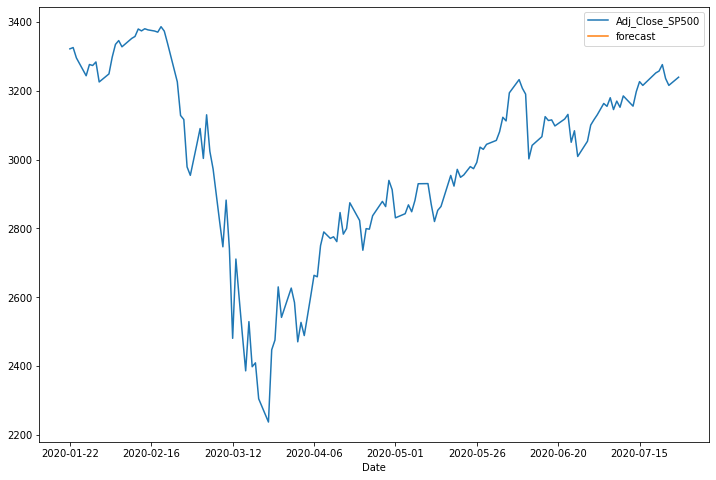

In [ ]:
arima_mod6 = sm.tsa.arima_model.ARIMA(df_snp500_covid['Adj_Close_SP500'], (2,1,1)).fit(disp=False)
print(arima_mod6.summary())

df_snp500_covid['forecast']=arima_mod6.predict(start=160,end=187,dynamic=True)
df_snp500_covid[['Adj_Close_SP500','forecast']].plot(figsize=(12,8))

In [ ]:
def history_stock_analysis(X_train, X_test, model):

    model.fit(X_train)
    stock_forecast = model.predict(n_periods=len(X_test))
    stock_forecast = pd.DataFrame(stock_forecast,index = X_test.index,columns=['Prediction'])
    actual_pred = stock_forecast.join(X_test)
    df = X_train.join(actual_pred,how="outer")

    actual_pred.plot(figsize=(7,4))

    df.plot(figsize=(10,5))

    return actual_pred

In [ ]:
X = df_snp500_covid['Adj_Close_SP500']
X_covid_train = pd.DataFrame(X[:150])
X_covid_train.columns = ['SNP COVID Train']
# X_train = X_train.set_index(df_with_missing[:150]["Date"])
X_covid_test = pd.DataFrame(X[151:])
X_covid_test.columns = ['SNP COVID Actual']
# X_test = X_test.set_index(df_with_missing[151:]["Date"])

In [ ]:
snp_covid_model = auto_arima(X_covid_train, start_p=1, start_q=1,
                    max_p=3, max_q=3, m=12,
                    start_P=0, seasonal=True,
                    d=1, D=1, trace=True,
                    error_action='ignore',  
                    suppress_warnings=True, 
                    stepwise=True) 

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1557.775, BIC=1572.375, Fit time=1.449 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1636.064, BIC=1641.904, Fit time=0.030 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1589.518, BIC=1601.198, Fit time=0.993 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1556.781, BIC=1568.461, Fit time=1.436 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=1558.713, BIC=1573.313, Fit time=2.571 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=1625.045, BIC=1633.804, Fit time=0.193 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=1558.714, BIC=1573.314, Fit time=4.885 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=1560.610, BIC=1578.130, Fit time=5.695 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=1559.921, BIC=1568.681, Fit time=0.737 seconds
Fit ARIMA: order=(0, 1, 2) s

            SNP COVID Train   Prediction  SNP COVID Actual
Date                                                      
2020-01-22      3321.750000          NaN               NaN
2020-01-23      3325.540039          NaN               NaN
2020-01-24      3295.469971          NaN               NaN
2020-01-25      3278.098532          NaN               NaN
2020-01-26      3260.818664          NaN               NaN
...                     ...          ...               ...
2020-07-23              NaN  3450.227685       3235.659912
2020-07-24              NaN  3491.368344       3215.629883
2020-07-25              NaN  3501.081050       3223.537100
2020-07-26              NaN  3502.672050       3231.463760
2020-07-27              NaN  3525.587131       3239.409912

[187 rows x 3 columns]


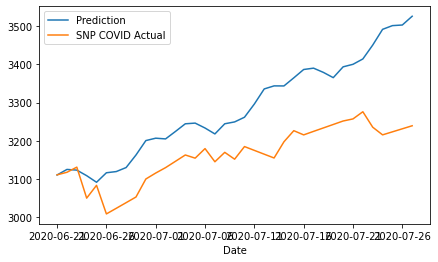

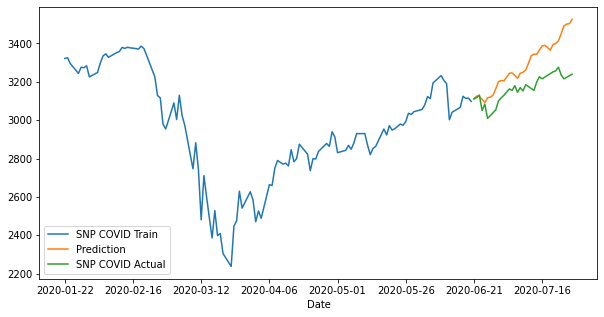

In [ ]:
history_stock_analysis(X_covid_train, X_covid_test, snp_model)

In [ ]:
# df_snp_combined = pd.concat([df_snp500_precovid[1292:]['Adj_Close_SP500'],df_snp500_covid['Adj_Close_SP500']], ignore_index=False)

# df_historical = pd.DataFrame(df_with_missing_historical['Adj_Close_SP500'])
# df_historical.columns = ['Train']
# df_historical = df_historical.set_index(df_with_missing_historical["Date"])

# df_covid = pd.DataFrame(df_with_missing['Adj_Close_SP500'])
# df_covid.columns = ['Actual']
# df_covid = df_covid.set_index(df_with_missing["Date"])


df_snp_train_376 = pd.DataFrame(df_snp500_precovid[1292:]['Adj_Close_SP500'])
df_snp_train_376.columns = ['SNP Train']

df_snp_test_376 = df_snp500_covid
df_snp_test_376.columns = ['Actual']

In [ ]:
snp_model_376 = auto_arima(df_snp_train_376, start_p=1, start_q=1,
                    max_p=3, max_q=3, m=12,
                    start_P=0, seasonal=True,
                    d=1, D=1, trace=True,
                    error_action='ignore',  
                    suppress_warnings=True, 
                    stepwise=True) 

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1540.275, BIC=1556.099, Fit time=2.614 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1637.302, BIC=1643.632, Fit time=0.031 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1590.021, BIC=1602.680, Fit time=0.810 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1542.285, BIC=1554.944, Fit time=1.145 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=1542.248, BIC=1561.237, Fit time=3.112 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=1631.725, BIC=1644.384, Fit time=0.738 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=1542.027, BIC=1561.016, Fit time=7.648 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=1544.111, BIC=1566.264, Fit time=9.116 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1543.295, BIC=1562.283, Fit time=1.727 seconds
Fit ARIMA: order=(1, 1, 0) s

              SNP Train   Prediction       Actual
Date                                             
2019-07-18  2995.110107          NaN          NaN
2019-07-19  2976.610107          NaN          NaN
2019-07-20  2979.414105          NaN          NaN
2019-07-21  2982.220745          NaN          NaN
2019-07-22  2985.030029          NaN          NaN
...                 ...          ...          ...
2020-07-23          NaN  4828.176052  3235.659912
2020-07-24          NaN  4837.178688  3215.629883
2020-07-25          NaN  4847.660318  3223.537100
2020-07-26          NaN  4861.761760  3231.463760
2020-07-27          NaN  4866.014466  3239.409912

[376 rows x 3 columns]


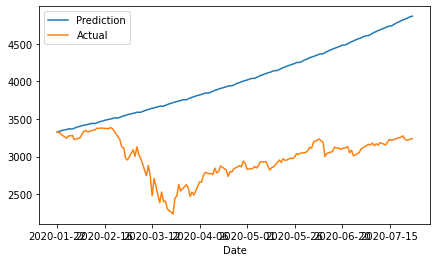

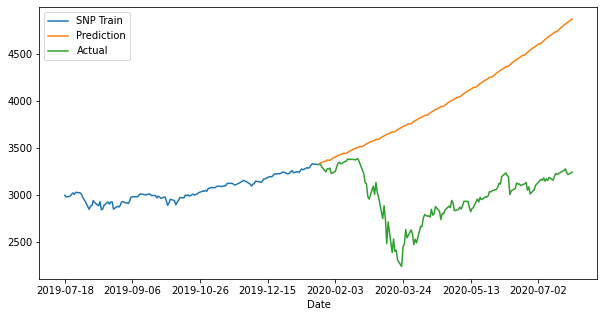

In [ ]:
history_stock_analysis(df_snp_train_376, df_snp_test_376, snp_model_376)

In [ ]:
snp_train_1668 = df_snp500_train
snp_train_1668.columns = ['SNP Train']
snp_test_1668 = df_snp500_test
snp_test_1668.columns = ['SNP Actual']

In [ ]:
snp_model_1668 = auto_arima(snp_train_1668, start_p=1, start_q=1,
                    max_p=3, max_q=3, m=12,
                    start_P=0, seasonal=True,
                    d=1, D=1, trace=True,
                    error_action='ignore',  
                    suppress_warnings=True, 
                    stepwise=True) 

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=10753.390, BIC=10779.179, Fit time=7.333 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=11658.390, BIC=11668.706, Fit time=0.099 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=11196.390, BIC=11217.021, Fit time=4.789 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=10753.046, BIC=10773.677, Fit time=4.020 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=10750.200, BIC=10775.989, Fit time=6.399 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=11196.389, BIC=11217.020, Fit time=3.676 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=10748.893, BIC=10779.839, Fit time=56.626 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=10749.510, BIC=10785.614, Fit time=69.071 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 2, 12); AIC=10749.148, BIC=10774.937, Fit time=40.250 seconds
Fit ARI

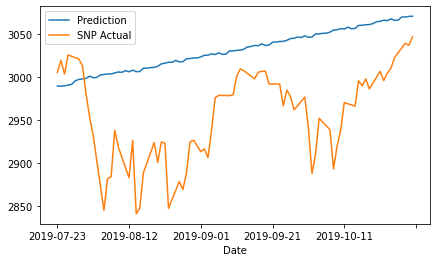

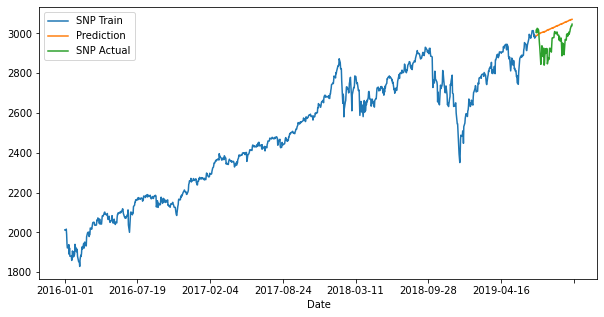

In [ ]:
df_snp_1668_actual_pred = history_stock_analysis(snp_train_1668, snp_test_1668[:100], snp_model_1668)

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
y_true = df_snp_1668_actual_pred['SNP Actual'].to_list()
y_pred = df_snp_1668_actual_pred['Prediction'].to_list()

forecast_errors = [y_true[i]-y_pred[i] for i in range(len(y_true))]
bias = sum(forecast_errors) * 1.0/len(y_true)
print('Bias: %f' % bias)


mae = mean_absolute_error(y_true, y_pred)
print('MAE: %f' % mae)


mse = mean_squared_error(y_true, y_pred)
rmse = math.sqrt(mse)
print('RMSE: %f' % rmse)

Bias: -118.334342
MAE: 180.814455
RMSE: 257.043603


## Kmeans Clustering Based on Trend and Seasonality

In [ ]:
trend_seasonality_df

,Unnamed: 0,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Date,Confirmed,Deaths,New_cases,Centroid_Distance,Trend,Seasonal,Residual
0,0,63072001,PR,PRI,630,72001.0,Adjuntas,Puerto Rico,US,18.180117,-66.754367,"Adjuntas, Puerto Rico, US",2020-1-22,0,0,0.0,2033.528929,0.000000,0.179398,-0.179398
1,1,63072003,PR,PRI,630,72003.0,Aguada,Puerto Rico,US,18.360255,-67.175131,"Aguada, Puerto Rico, US",2020-1-22,0,0,0.0,2006.058450,0.000000,-0.217683,0.217683
2,2,63072005,PR,PRI,630,72005.0,Aguadilla,Puerto Rico,US,18.459681,-67.120815,"Aguadilla, Puerto Rico, US",2020-1-22,0,0,0.0,2003.225492,0.000000,-0.448518,0.448518
3,3,63072007,PR,PRI,630,72007.0,Aguas Buenas,Puerto Rico,US,18.251619,-66.126806,"Aguas Buenas, Puerto Rico, US",2020-1-22,0,0,0.0,2057.093220,0.000000,-0.047403,0.047403
4,4,63072009,PR,PRI,630,72009.0,Aibonito,Puerto Rico,US,18.131361,-66.264131,"Aibonito, Puerto Rico, US",2020-1-22,0,0,0.0,2057.292797,0.000000,0.501004,-0.501004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605355,605355,84056037,US,USA,840,56037.0,Sweetwater,Wyoming,US,41.659439,-108.882788,"Sweetwater, Wyoming, US",2020-7-27,221,0,6.0,962.070295,6.905774,-0.410884,-0.494890
605356,605356,84056039,US,USA,840,56039.0,Teton,Wyoming,US,43.935225,-110.589080,"Teton, Wyoming, US",2020-7-27,292,0,13.0,1074.431743,6.771222,0.318466,5.910312
605357,605357,84056041,US,USA,840,56041.0,Uinta,Wyoming,US,41.287818,-110.547578,"Uinta, Wyoming, US",2020-7-27,235,0,2.0,1045.925047,0.686254,-0.538403,1.852149
605358,605358,84056043,US,USA,840,56043.0,Washakie,Wyoming,US,43.904516,-107.680187,"Washakie, Wyoming, US",2020-7-27,45,0,0.0,933.668312,0.256159,0.055595,-0.311753


In [ ]:
trend_seasonality_df.loc[trend_seasonality_df['Province_State'] == "Texas"]

,Unnamed: 0,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Date,Confirmed,Deaths,New_cases,Centroid_Distance,Trend,Seasonal,Residual
2601,2601,84048001,US,USA,840,48001.0,Anderson,Texas,US,31.815347,-95.653548,"Anderson, Texas, US",2020-1-22,0,0,0.0,538.417771,0.000000,-11.168692,11.168692
2602,2602,84048003,US,USA,840,48003.0,Andrews,Texas,US,32.304686,-102.637655,"Andrews, Texas, US",2020-1-22,0,0,0.0,784.210731,0.000000,-0.406278,0.406278
2603,2603,84048005,US,USA,840,48005.0,Angelina,Texas,US,31.254573,-94.609015,"Angelina, Texas, US",2020-1-22,0,0,0.0,548.886764,0.000000,-2.812041,2.812041
2604,2604,84048007,US,USA,840,48007.0,Aransas,Texas,US,28.105562,-96.999505,"Aransas, Texas, US",2020-1-22,0,0,0.0,803.948972,0.000000,-0.528797,0.528797
2605,2605,84048009,US,USA,840,48009.0,Archer,Texas,US,33.615700,-98.687546,"Archer, Texas, US",2020-1-22,0,0,0.0,549.219232,0.000000,-0.085856,0.085856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604990,604990,84048499,US,USA,840,48499.0,Wood,Texas,US,32.787224,-95.382364,"Wood, Texas, US",2020-7-27,241,5,0.0,471.952754,6.393581,-1.441491,-4.952090
604991,604991,84048501,US,USA,840,48501.0,Yoakum,Texas,US,33.173202,-102.827643,"Yoakum, Texas, US",2020-7-27,63,1,0.0,758.652499,2.081350,-0.458206,-1.623144
604992,604992,84048503,US,USA,840,48503.0,Young,Texas,US,33.176597,-98.687909,"Young, Texas, US",2020-7-27,101,3,0.0,569.766770,3.408407,-0.749694,-2.658713
604993,604993,84048505,US,USA,840,48505.0,Zapata,Texas,US,27.001564,-99.169872,"Zapata, Texas, US",2020-7-27,123,1,0.0,930.590582,4.053095,-0.572814,-3.480280


In [ ]:
trend_seasonality_df_20200415 = trend_seasonality_df.loc[trend_seasonality_df['Date'] == "2020-4-15"]

In [ ]:
trend_seasonality_df_compressed = trend_seasonality_df_20200415[["Combined_Key", "Trend", "Seasonal"]] 

In [ ]:
X= trend_seasonality_df_compressed.iloc[:, [1,2]].values

In [ ]:
from sklearn.cluster import KMeans
kmeans_inertia=[]

for i in range(1,11):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
    kmeans.fit(X)
    kmeans_inertia.append(kmeans.inertia_)

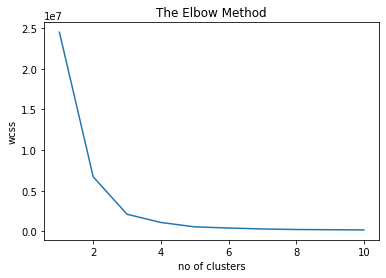

In [ ]:
plt.plot(range(1,11), kmeans_inertia)
plt.title('The Elbow Method')
plt.xlabel('no of clusters')
plt.ylabel('wcss')
plt.show()

In [ ]:
kmeansmodel = KMeans(n_clusters= 3, init='k-means++', random_state=0)
y_kmeans= kmeansmodel.fit_predict(X)

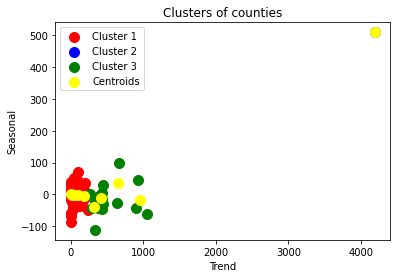

In [ ]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
# plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
# plt.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')
plt.title('Clusters of counties')
plt.xlabel('Trend')
plt.ylabel('Seasonal')
plt.legend()
plt.show()

In [ ]:
trend_seasonality_df_compressed.insert(3, "Cluster Group", y_kmeans, True)

In [ ]:
trend_seasonality_df_compressed

,Combined_Key,Trend,Seasonal,Cluster Group,Cluster Group
270480,"Adjuntas, Puerto Rico, US",0.000000,-0.430077,0,0
270481,"Aguada, Puerto Rico, US",0.000000,-0.350531,0,0
270482,"Aguadilla, Puerto Rico, US",0.000000,-0.693597,0,0
270483,"Aguas Buenas, Puerto Rico, US",0.000000,-0.532086,0,0
270484,"Aibonito, Puerto Rico, US",0.000000,-0.219110,0,0
...,...,...,...,...,...
273695,"Sweetwater, Wyoming, US",0.533333,0.055453,0,0
273696,"Teton, Wyoming, US",2.600000,-0.955285,0,0
273697,"Uinta, Wyoming, US",0.266667,-0.550407,0,0
273698,"Washakie, Wyoming, US",0.233333,-0.071784,0,0


In [ ]:
trend_seasonality_df_compressed.loc[trend_seasonality_df_compressed['Combined_Key'] == "Alachua, Florida, US"]

,Combined_Key,Trend,Seasonal,Cluster Group,Cluster Group
270878,"Alachua, Florida, US",6.05,-2.884529,0,0


In [ ]:
trend_seasonality_df_compressed.loc[trend_seasonality_df_compressed['Combined_Key'] == "Aransas, Texas, US"]

,Combined_Key,Trend,Seasonal,Cluster Group,Cluster Group
273084,"Aransas, Texas, US",0.033333,-0.575972,0,0


# Random Forest for Stock Prediction

In [106]:
df_snp500_original.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-10-26,2075.080078,2075.139893,2066.530029,2071.179932,2071.179932,3385800000
1,2015-10-27,2068.750000,2070.370117,2058.840088,2065.889893,2065.889893,4216880000
2,2015-10-28,2066.479980,2090.350098,2063.110107,2090.350098,2090.350098,4698110000
3,2015-10-29,2088.350098,2092.520020,2082.629883,2089.409912,2089.409912,4008940000
4,2015-10-30,2090.000000,2094.320068,2079.340088,2079.360107,2079.360107,4256200000


In [111]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# The prediction is based on 'Open', 'High', 'Low', 'Close', 'Volume' paramters 
X_Cols = df_snp500_original[['Open', 'High', 'Low', 'Close', 'Volume']]
Y_Cols = df_snp500_original['Adj Close']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# scale the stock data
standard_scalar = StandardScaler()

X_train = standard_scalar.fit_transform(X_train)

X_test = standard_scalar.fit_transform(X_test)

random_forest_regressor = RandomForestRegressor(n_estimators=1, max_depth=2, bootstrap=False, min_samples_leaf=1)

# Fit the stock data to the model
random_forest_regressor.fit(X_train, y_train)

# Make predictions
y_prediction = random_forest_regressor.predict(X_test)
print("The r2 values of the prediction is : ", r2_score(y_test, y_pred))


The r2 values of the prediction is :  0.9218324681281791


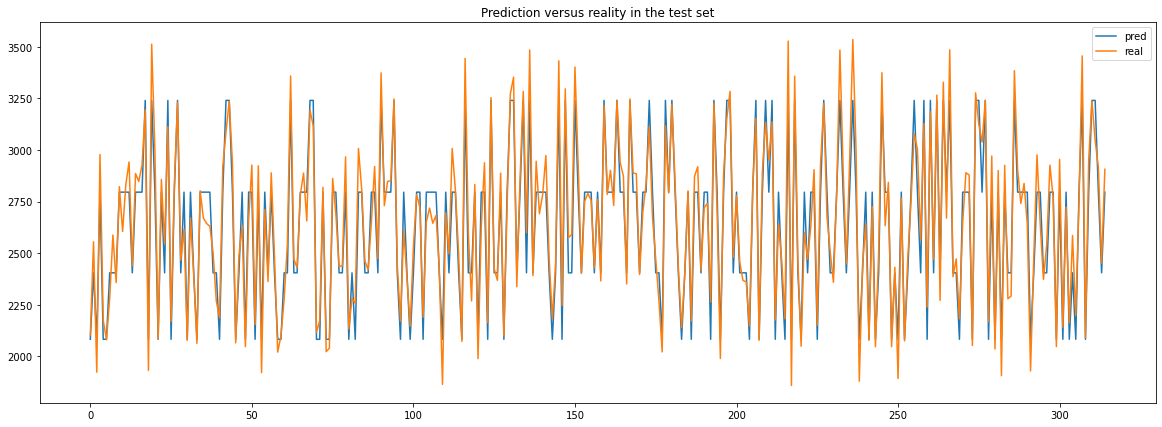

In [112]:
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(y_prediction)), y_prediction, label='pred')
plt.plot(np.arange(len(y_prediction)), y_test, label='real')
plt.title('Prediction versus reality in the test set')
plt.legend()

# Causation Analysis on COVID and Stock Data


In [122]:
df_snp500 = df_with_missing[['Date','Adj_Close_SP500']]
df_snp500["Date"] = pd.to_datetime(df_snp500["Date"])
df_snp500 = df_snp500.set_index("Date")
df_snp500

,Adj_Close_SP500
Date,
2020-01-22,3321.750000
2020-01-23,3325.540039
2020-01-24,3295.469971
2020-01-25,3278.098532
2020-01-26,3260.818664
...,...
2020-07-23,3235.659912
2020-07-24,3215.629883
2020-07-25,3223.537100


In [123]:
df_snp500.sort_index(inplace= True)
decomposition_seasonal = seasonal_decompose(df_snp500["Adj_Close_SP500"].values, freq=30, extrapolate_trend='freq')

residual = decomposition_seasonal.resid
seasonal = decomposition_seasonal.seasonal 
trend = decomposition_seasonal.trend

trend_to_plot = trend.tolist()


In [124]:
trend_seasonality_df = trend_seasonality_df[trend_seasonality_df["Trend"] > 0]
groupby_daily = trend_seasonality_df.groupby(trend_seasonality_df["Date"])
array_plot_trend_average = []
for name, group in groupby_daily: 
  array_plot_trend_average.append(group["Trend"].mean())


,trend,trend_average_covid
0,0.006399,0.000036
1,0.006372,0.000036
2,0.006345,0.000036
3,0.006319,0.000035
4,0.006292,0.000035
...,...,...
183,0.005659,0.011076
184,0.005665,0.011316
185,0.005670,0.011558
186,0.005675,0.011803


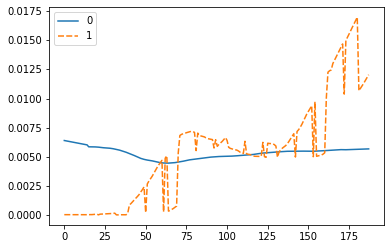

In [126]:
df = pd.DataFrame(
    {'trend': trend_to_plot,
     'trend_average_covid': array_plot_trend_average
    })



normalization_1 = [float(i)/sum(trend_to_plot) for i in trend_to_plot]
normalization_2 = [float(i)/sum(array_plot_trend_average) for i in array_plot_trend_average]


sns.lineplot(data=[normalization_1, normalization_2])

df_norm = pd.DataFrame(
    {'trend': normalization_1,
     'trend_average_covid': normalization_2
    })

df_norm